In [1]:
using QuantumCumulants, HarmonicBalance
using ModelingToolkit, OrderedCollections

## Cumulant Expansion Equations for driven KPO

In [71]:
# Define hilbert space
h = FockSpace(:cavity1)

# Define the fundamental operators
@qnumbers a1::Destroy(h, 1) b1::Destroy(h, 1)

# Define parameters
@rnumbers ω₀ ωₚ U F G κ U_b F_b G_b

@syms t::Real

# Hamiltonian

H_RWA_a = (ω₀ - ωₚ + U) * a1' * a1 + 1 / 2 * U * (a1'^2 * a1^2) + F * (a1 + a1') + G' / 2 * a1^2 + G / 2 * a1'^2

# Collapse operators
rates = [κ];
Jop = [a1]

# Derive equations
ops_a = [a1]
n_order_MF = 1

eqs_RWA_a   = meanfield(ops_a, H_RWA_a, Jop; rates=rates, order=n_order_MF)
eqs_RWA_a_c = meanfield([c' for c in ops_a], H_RWA_a, Jop; rates=rates, order=n_order_MF)

eqs_completed_RWA_a   = complete(eqs_RWA_a)

∂ₜ(⟨a1⟩) = (0 - 1im)*F + (0//1 - 1//1*im)*G*⟨a1′⟩ + (0 - 1im)*(U + ω₀ - ωₚ)*⟨a1⟩ - 0.5⟨a1⟩*κ + (0.0 - 1.0im)*U*(⟨a1⟩^2)*⟨a1′⟩


## Philosophy:
#### map average values to complex Symbolics variables $z_i$ by 
(i) converting the equations to strings (ii) parsing them into symbols, (iii) evaluate the expressions. Then take real and imaginary parts. 

This approach does not directly lead to independent variables. To tackle this, we introduce additional constraints between the variables 
*(1) the average value of a Hermitian operator is real, so imaginary parts go to zero, and 
*(2) for complex conjugate average values, real parts are identical and imaginary parts are negative of each other]


In [72]:
using HomotopyContinuation

In [73]:
function replace_multiple(original::String, replacements::Dict{String,String})::String
    # Start with the original string
    new_string = original
    
    # Iterate over the dictionary
    for (old, new) in replacements
        # Replace each occurrence of 'old' with 'new'
        new_string = replace(new_string, old => new)
    end
    
    return new_string
end

# Function to convert a number into its Unicode subscript representation
function number_to_subscript(n::Int)
    # Unicode subscript characters for digits 0-9
    subscripts = ['₀', '₁', '₂', '₃', '₄', '₅', '₆', '₇', '₈', '₉']
    subscript_str = ""
    
    # Convert each digit of the number into its subscript equivalent
    for digit_char in string(n)
        digit = parse(Int, digit_char)  # Convert character to integer
        subscript_str *= subscripts[digit + 1]  # Append subscript character
    end
    
    return subscript_str
end

# Function to generate variable names with subscripts based on indices
function indices_to_subscript_vars(indices)
    symbolic_vars = []  # Initialize an empty array of symbols
    
    for i in indices
        subscript = number_to_subscript(i)  # Convert index to subscript
        var_name = "z$(subscript)"  # Create the variable name with subscript
        push!(symbolic_vars, var_name)  
    end
    
    return symbolic_vars
end


indices_to_subscript_vars (generic function with 1 method)

In [74]:
function convert_to_symbolic_eqs_alt(eqs::MeanfieldEquations)
    @named sys = ODESystem(eqs_completed_RWA_a)
    params = sys.ps.value

    
    ops_av = average.(union(eqs.operators,[c' for c in eqs.operators])) #will include the Hermitian conjugates
    
    @var z[1:length(string.(ops_av))]
    eqs = [eq.rhs for eq in eqs.equations]

    Z = [string(zz) for zz in z]
    mapping =  Dict(zip(string.(ops_av),Z))

    eqs_complex = [replace_multiple(string(eq),mapping) for eq in eqs]

    eqs_ =  [Meta.parse(s) for s in eqs_complex]

    #zz  = indices_to_subscript_vars(1:length(string.(ops_av)))

    return eqs_,Z,mapping
end


eqs_,zz,mapping = convert_to_symbolic_eqs_alt(eqs_completed_RWA_a)

@eval @variables ω₀ ωₚ U F G κ

# Array of variable names
#zzR = [s * "\u1D63" for s in zz]
#zzI = [s * "\u1D62" for s in zz]

zzR = replace.(zz,"z"=>"R")
zzI = replace.(zz,"z"=>"I")

vars_z = []
vars_R = []
vars_I = []
for (name_z,name_R,name_I) in zip(zz,zzR,zzI)
    push!(vars_z,@eval @variables $(Symbol(name_z))::Complex{Real})  # Convert string name to Symbol and declare it as a variable
    push!(vars_R,@eval @variables $(Symbol(name_R))::Real) 
    push!(vars_I,@eval @variables $(Symbol(name_I))::Real)
end

eqs = eval.(eqs_)

eqs_R = [substitute(real(eq),Dict(zip([real(z_)[1] for z_ in vars_z],[zR[1] for zR in vars_R]))) for eq in eqs]
eqs_R = [substitute(eq,Dict(zip([imag(z_)[1] for z_ in vars_z],[zI[1] for zI in vars_I]))) for eq in eqs_R]


eqs_I = [substitute(imag(eq),Dict(zip([real(z_)[1] for z_ in vars_z],[zR[1] for zR in vars_R]))) for eq in eqs]
eqs_I = [substitute(eq,Dict(zip([imag(z_)[1] for z_ in vars_z],[zI[1] for zI in vars_I]))) for eq in eqs_I];

eqs_reim  = reduce(vcat,[eqs_R ,eqs_I])
vars_reim = reduce(vcat,[[v[1] for v in vars_R],[v[1] for v in vars_I]])

4-element Vector{Num}:
 R₁
 R₂
 I₁
 I₂

## without additional constraints, the system contains more equations than variables (is non-square)

In [75]:
parameters = [ω₀,ωₚ,U,F,G,κ]
prob = HarmonicBalance.Problem(eqs_reim,vars_reim,parameters)

LoadError: Jacobians are only defined for square systems!

In [76]:
print(length(eqs_reim),",",length(vars_reim)) #more unknowns than equations, but additional constraints exist (e.g. the photon number expectation value is real)

2,4

In [77]:
vars_I

2-element Vector{Any}:
 Num[I₁]
 Num[I₂]

In [78]:
mapping

Dict{String, String} with 2 entries:
  "⟨a1⟩"  => "z₁"
  "⟨a1′⟩" => "z₂"

In [79]:
#extra_eqs = [I₂,#I₂~0
#             R₁ - R₄, #"Re⟨a1⟩ = Re⟨a1′⟩"
#             R₃ - R₅, #"Re⟨a1*a1⟩ = Re⟨a1′*a1′⟩"
#             I₂ + I₅] #"Im⟨a1*a1⟩ =-Im⟨a1′*a1′⟩"

extra_eqs = [R₁ - R₂, #"Re⟨a1⟩ = Re⟨a1′⟩"
             I₁ + I₂] #"Im⟨a1⟩ = -Im⟨a1′⟩"


prob_ext = HarmonicBalance.Problem(vcat(eqs_reim,extra_eqs),vars_reim,parameters)

4 algebraic equations for steady states
Variables: R₁, R₂, I₁, I₂
Parameters: ω₀, ωₚ, U, F, G, κ
Symbolic Jacobian: true


In [80]:
prob_ext.system

System of length 4
 4 variables: R₁, R₂, I₁, I₂
 6 parameters: ω₀, ωₚ, U, F, G, κ

 G*I₂ - 0.5*κ*R₁ + (U + ω₀ - ωₚ)*I₁ + U*(-I₁^2 + R₁^2)*I₂ + 2.0*U*R₂*R₁*I₁
 -F - G*R₂ - 0.5*κ*I₁ + (-U - ω₀ + ωₚ)*R₁ - U*(-I₁^2 + R₁^2)*R₂ + 2.0*U*R₁*I₁*I₂
 R₁ - R₂
 I₁ + I₂

In [81]:
prob_ext.parameters

6-element Vector{Num}:
 ω₀
 ωₚ
  U
   F
  G
  κ

In [82]:
using HarmonicBalance
# declare constant variables and two functions x(t) and y(t)
@variables q(t), p(t), r(t), s(t), t

# differential equations
diff_eq = DifferentialEquation([d(q,t,2) ~ 0, d(p,t,2) ~ 0], [p,q])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, p, ω₀)
add_harmonic!(diff_eq, q, ω₀)

# implement ansatz to get harmonic equations
harmonic_eq_dummy = get_harmonic_equations(diff_eq)

prob_ext.eom = harmonic_eq_dummy;
prob_ext.system

System of length 4
 4 variables: R₁, R₂, I₁, I₂
 6 parameters: ω₀, ωₚ, U, F, G, κ

 G*I₂ - 0.5*κ*R₁ + (U + ω₀ - ωₚ)*I₁ + U*(-I₁^2 + R₁^2)*I₂ + 2.0*U*R₂*R₁*I₁
 -F - G*R₂ - 0.5*κ*I₁ + (-U - ω₀ + ωₚ)*R₁ - U*(-I₁^2 + R₁^2)*R₂ + 2.0*U*R₁*I₁*I₂
 R₁ - R₂
 I₁ + I₂

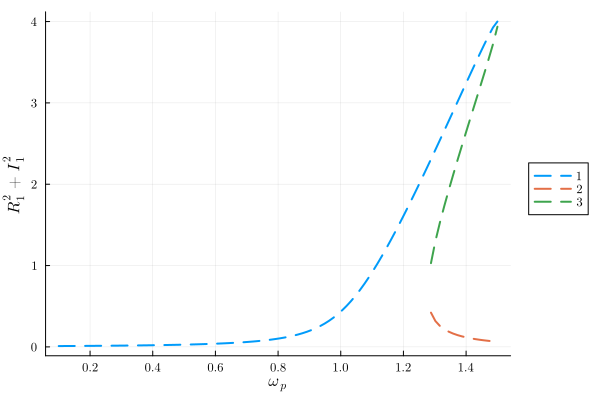

In [83]:
fixed = (U=>0.1,ω₀=>1.,F=>0.1 ,G=>0.,κ =>0.1)
varied = ωₚ => LinRange(0.1,1.5,100)

# results
result_MF = get_steady_states(prob_ext, varied, fixed)
plot(result_MF,y="R₁^2+I₁^2") #the complex jacobian needs shifted by -1.0im because of 1.0im factor in Heisenberg equations. This exchanges stable and unstable solutions

## Include Higher cumulants

In [84]:
n_order_MF = 2

eqs_RWA_a   = meanfield(ops_a, H_RWA_a, Jop; rates=rates, order=n_order_MF)
eqs_RWA_a_c = meanfield([c' for c in ops_a], H_RWA_a, Jop; rates=rates, order=n_order_MF)

eqs_completed_RWA_a   = complete(eqs_RWA_a)

∂ₜ(⟨a1⟩) = (0 - 1im)*F + (0//1 - 1//1*im)*G*⟨a1′⟩ + (0 - 1im)*(U + ω₀ - ωₚ)*⟨a1⟩ - 0.5⟨a1⟩*κ + (0.0 - 1.0im)*U*(2⟨a1⟩*⟨a1′*a1⟩ + ⟨a1*a1⟩*⟨a1′⟩ - 2(⟨a1⟩^2)*⟨a1′⟩)
∂ₜ(⟨a1′*a1⟩) = (0 + 1im)*F*⟨a1⟩ + (0 - 1im)*F*⟨a1′⟩ + (0//1 + 1//1*im)*G*⟨a1*a1⟩ + (0//1 - 1//1*im)*G*⟨a1′*a1′⟩ - ⟨a1′*a1⟩*κ
∂ₜ(⟨a1*a1⟩) = (0//1 - 1//1*im)*G + (0 - 2im)*F*⟨a1⟩ + (0//1 - 2//1*im)*G*⟨a1′*a1⟩ + (0 - 2im)*(U + ω₀ - ωₚ)*⟨a1*a1⟩ + (0.0 - 1.0im)*U*⟨a1*a1⟩ - ⟨a1*a1⟩*κ + (0.0 - 2.0im)*U*(3⟨a1*a1⟩*⟨a1′*a1⟩ - 6(⟨a1⟩^2)*⟨a1′*a1⟩ - 6⟨a1⟩*⟨a1*a1⟩*⟨a1′⟩ + 6(⟨a1⟩^3)*⟨a1′⟩ + (3⟨a1⟩*⟨a1*a1⟩ - 2(⟨a1⟩^3))*⟨a1′⟩ + 3⟨a1⟩*(2⟨a1⟩*⟨a1′*a1⟩ + ⟨a1*a1⟩*⟨a1′⟩ - 2(⟨a1⟩^2)*⟨a1′⟩))


In [85]:
eqs_,zz,mapping = convert_to_symbolic_eqs_alt(eqs_completed_RWA_a)

@eval @variables ω₀ ωₚ U F G κ

# Array of variable names
#zzR = [s * "\u1D63" for s in zz]
#zzI = [s * "\u1D62" for s in zz]

zzR = replace.(zz,"z"=>"R")
zzI = replace.(zz,"z"=>"I")

vars_z = []
vars_R = []
vars_I = []
for (name_z,name_R,name_I) in zip(zz,zzR,zzI)
    push!(vars_z,@eval @variables $(Symbol(name_z))::Complex{Real})  # Convert string name to Symbol and declare it as a variable
    push!(vars_R,@eval @variables $(Symbol(name_R))::Real) 
    push!(vars_I,@eval @variables $(Symbol(name_I))::Real)
end

eqs = eval.(eqs_)

eqs_R = [substitute(real(eq),Dict(zip([real(z_)[1] for z_ in vars_z],[zR[1] for zR in vars_R]))) for eq in eqs]
eqs_R = [substitute(eq,Dict(zip([imag(z_)[1] for z_ in vars_z],[zI[1] for zI in vars_I]))) for eq in eqs_R]


eqs_I = [substitute(imag(eq),Dict(zip([real(z_)[1] for z_ in vars_z],[zR[1] for zR in vars_R]))) for eq in eqs]
eqs_I = [substitute(eq,Dict(zip([imag(z_)[1] for z_ in vars_z],[zI[1] for zI in vars_I]))) for eq in eqs_I];

eqs_reim  = reduce(vcat,[eqs_R ,eqs_I])
vars_reim = reduce(vcat,[[v[1] for v in vars_R],[v[1] for v in vars_I]]);

In [86]:
eqs_reim

6-element Vector{Num}:
 G*I₄ + I₁*(U + ω₀ - ωₚ) - 0.5R₁*κ + (2I₁*R₂ + 2I₂*R₁ + I₃*R₄ + I₄*R₃ - 2(-(I₁^2) + R₁^2)*I₄ - 4I₁*R₁*R₄)*U
                           -F*I₁ + F*I₄ - G*I₃ + G*I₅ - R₂*κ
                           2F*I₁ + (2//1)*G*I₂ + 2I₃*(U + ω₀ - ωₚ) + I₃*U - R₃*κ + 2.0(3I₂*R₃ + 3I₃*R₂ - 6(-(I₁^2) + R₁^2)*I₂ - (-6I₁*I₃ + 6R₁*R₃)*I₄ - 12I₁*R₁*R₂ + (-6I₁*R₃ - 6I₃*R₁)*R₄ + 3(2I₁*R₂ + 2I₂*R₁ + I₃*R₄ + I₄*R₃ - 2(-(I₁^2) + R₁^2)*I₄ - 4I₁*R₁*R₄)*R₁ + (-3I₁*I₃ + 3R₁*R₃ - 2((-(I₁^2) + R₁^2)*R₁ - 2(I₁^2)*R₁))*I₄ + 6((-(I₁^2) + R₁^2)*R₁ - 2(I₁^2)*R₁)*I₄ + (3I₁*R₃ + 3I₃*R₁ - 2(I₁*(-(I₁^2) + R₁^2) + 2I₁*(R₁^2)))*R₄ + 6(I₁*(-(I₁^2) + R₁^2) + 2I₁*(R₁^2))*R₄ + 3I₁*(-2I₁*I₂ - I₃*I₄ + 2R₁*R₂ + R₃*R₄ - 2(-(I₁^2) + R₁^2)*R₄ + 4I₁*I₄*R₁))*U
                           -F - G*R₄ - 0.5I₁*κ + R₁*(-U - ω₀ + ωₚ) + (2.0I₁*I₂ + I₃*I₄ - 2.0R₁*R₂ - R₃*R₄ + 2.0(-(I₁^2) + R₁^2)*R₄ - 4.0I₁*I₄*R₁)*U
                            F*R₁ - F*R₄ + G*R₃ - G*R₅ - I₂*κ
                      -G - 2F*R₁ - (2//1)*G*R₂ - I₃*κ

In [87]:
mapping

Dict{String, String} with 5 entries:
  "⟨a1⟩"      => "z₁"
  "⟨a1*a1⟩"   => "z₃"
  "⟨a1′⟩"     => "z₄"
  "⟨a1′*a1′⟩" => "z₅"
  "⟨a1′*a1⟩"  => "z₂"

In [88]:
parameters = [ω₀,ωₚ,U,F,G,κ]

extra_eqs = [#I₂,#I₂~0
             R₁ - R₄, #"Re⟨a1⟩ = Re⟨a1′⟩"
             I₁ + I₄, #"Re⟨a1⟩ = Re⟨a1′⟩"
             R₃ - R₅, #"Re⟨a1*a1⟩ = Re⟨a1′*a1′⟩"
             I₃ + I₅] #"Im⟨a1*a1⟩ =-Im⟨a1′*a1′⟩"


prob_ext = HarmonicBalance.Problem(vcat(eqs_reim,extra_eqs),vars_reim,parameters)

10 algebraic equations for steady states
Variables: R₁, R₂, R₃, R₄, R₅, I₁, I₂, I₃, I₄, I₅
Parameters: ω₀, ωₚ, U, F, G, κ
Symbolic Jacobian: true


In [89]:
prob_ext

10 algebraic equations for steady states
Variables: R₁, R₂, R₃, R₄, R₅, I₁, I₂, I₃, I₄, I₅
Parameters: ω₀, ωₚ, U, F, G, κ
Symbolic Jacobian: true


In [90]:
# declare constant variables and two functions x(t) and y(t)
@variables q(t), p(t), r(t), s(t), u(t), t

# differential equations
diff_eq = DifferentialEquation([d(p,t,2) ~ 0, d(q,t,2) ~ 0, d(r,t,2) ~ 0,d(s,t,2) ~ 0,d(u,t,2) ~ 0], [p,q,r,s,u])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, p, ω₀)
add_harmonic!(diff_eq, q, ω₀)
add_harmonic!(diff_eq, r, ω₀)
add_harmonic!(diff_eq, s, ω₀)
add_harmonic!(diff_eq, u, ω₀)

# implement ansatz to get harmonic equations
harmonic_eq_dummy = get_harmonic_equations(diff_eq)

prob_ext.eom = harmonic_eq_dummy;
prob_ext.system

System of length 10
 10 variables: R₁, R₂, R₃, R₄, R₅, I₁, I₂, I₃, I₄, I₅
 6 parameters: ω₀, ωₚ, U, F, G, κ

 G*I₄ + U*(2*R₁*I₂ + 2*R₂*I₁ + R₃*I₄ + R₄*I₃ - 2*(-I₁^2 + R₁^2)*I₄ - 4*R₄*R₁*I₁) - 0.5*κ*R₁ + (U + ω₀ - ωₚ)*I₁
 -F*I₁ + F*I₄ - G*I₃ + G*I₅ - κ*R₂
 2*F*I₁ + 2*G*I₂ + U*I₃ + 2.0*U*(3*I₁*(-2*I₁*I₂ - I₃*I₄ + 2*R₂*R₁ + R₄*R₃ - 2*(-I₁^2 + R₁^2)*R₄ + 4*R₁*I₁*I₄) + 6*I₄*(-2*R₁*I₁^2 + (-I₁^2 + R₁^2)*R₁) + I₄*(-3*I₁*I₃ + 3*R₃*R₁ - 2*(-2*R₁*I₁^2 + (-I₁^2 + R₁^2)*R₁)) + 3*R₁*(2*R₁*I₂ + 2*R₂*I₁ + R₃*I₄ + R₄*I₃ - 2*(-I₁^2 + R₁^2)*I₄ - 4*R₄*R₁*I₁) + 3*R₂*I₃ + 3*R₃*I₂ + 6*R₄*(2*R₁^2*I₁ + (-I₁^2 + R₁^2)*I₁) + R₄*(3*R₁*I₃ + 3*R₃*I₁ - 2*(2*R₁^2*I₁ + (-I₁^2 + R₁^2)*I₁)) - (-6*I₁*I₃ + 6*R₃*R₁)*I₄ + (-6*R₁*I₃ - 6*R₃*I₁)*R₄ - 6*(-I₁^2 + R₁^2)*I₂ - 12*R₂*R₁*I₁) - κ*R₃ + 2*(U + ω₀ - ωₚ)*I₃
 -F - G*R₄ + U*(2.0*I₁*I₂ + I₃*I₄ - 2.0*R₂*R₁ - R₄*R₃ + 2.0*(-I₁^2 + R₁^2)*R₄ - 4.0*R₁*I₁*I₄) - 0.5*κ*I₁ + (-U - ω₀ + ωₚ)*R₁
 F*R₁ - F*R₄ + G*R₃ - G*R₅ - κ*I₂
 -G - 2*F*R₁ - 2*G*R₂ - U*R₃ - 2.0*U*(-3*I₁*(2*R₁*I₂ + 2*R

In [103]:
fixed = (U=>0.1,ω₀=>1.,F=>0.1 ,G=>0.,κ =>0.1)
varied = ωₚ => LinRange(0.1,2.5,100)

# results
result = get_steady_states(prob_ext, varied, fixed)

A steady state result for 100 parameter points

Solution branches:   9
   of which real:    7
   of which stable:  0

Classes: stable, physical, Hopf, binary_labels


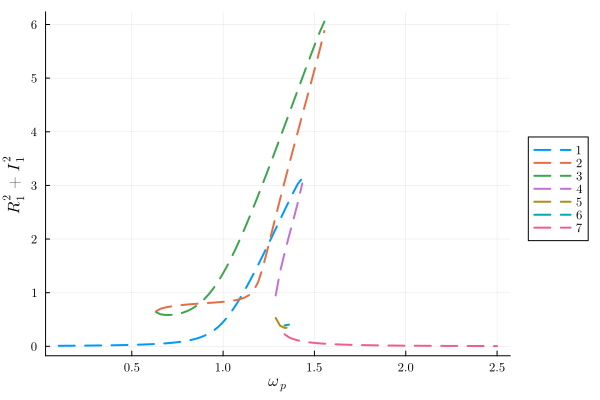

In [104]:
plot(result,y="R₁^2+I₁^2") #the complex jacobian needs shifted by -1.0im because of 1.0im factor in Heisenberg equations. This exchanges stable and unstable solutions

┌ Warning: Values with non-negligible complex parts have
│             been projected on the real axis! branch 1
└ @ HarmonicBalance ~/.julia/packages/HarmonicBalance/9XVui/src/plotting_Plots.jl:114
┌ Warning: Values with non-negligible complex parts have
│             been projected on the real axis! branch 2
└ @ HarmonicBalance ~/.julia/packages/HarmonicBalance/9XVui/src/plotting_Plots.jl:114
┌ Warning: Values with non-negligible complex parts have
│             been projected on the real axis! branch 3
└ @ HarmonicBalance ~/.julia/packages/HarmonicBalance/9XVui/src/plotting_Plots.jl:114
┌ Warning: Values with non-negligible complex parts have
│             been projected on the real axis! branch 6
└ @ HarmonicBalance ~/.julia/packages/HarmonicBalance/9XVui/src/plotting_Plots.jl:114
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191


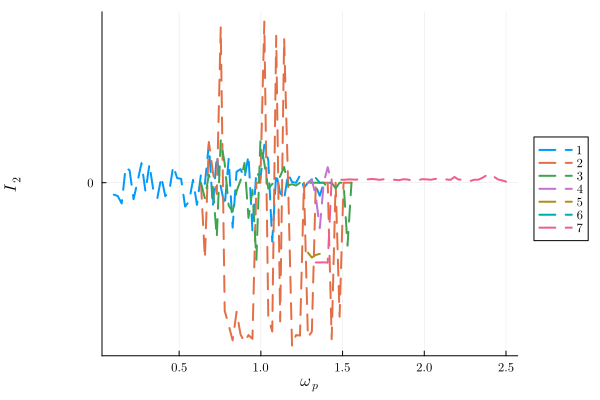

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191


In [105]:
plot(result,y="I₂") #check the population of the resonator is real

Compare Mean field with second order cumulants (careful that the mapping is consisten in both cases!)

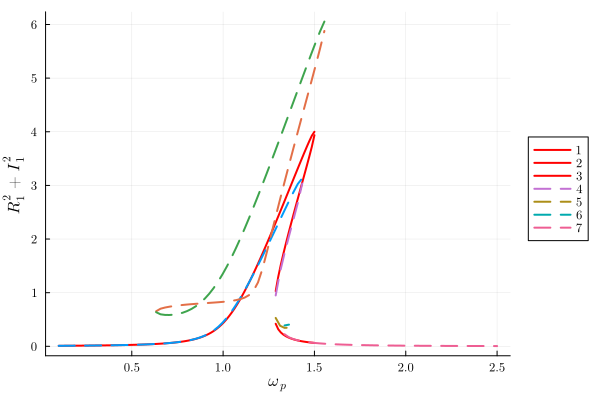

In [106]:

plot(result_MF,y="R₁^2+I₁^2",color="red",style=:solid) 
plot!(result,y="R₁^2+I₁^2") 